In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [2]:
# load env variables from .env file
import dotenv
dotenv.load_dotenv()

True

In [3]:
from langchain_openai import ChatOpenAI

model_id = "gpt-4o-2024-08-06"

from langchain_core.rate_limiters import InMemoryRateLimiter

rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.05,  # <-- Super slow! We can only make a request once every 10 seconds!!
    check_every_n_seconds=0.1,  # Wake up every 100 ms to check whether allowed to make a request,
    max_bucket_size=10,  # Controls the maximum burst size.
)

llm = ChatOpenAI(
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
# graph_builder.add_node("chatbot", chatbot)

In [4]:
graph = graph_builder.compile()

ValueError: Graph must have an entrypoint: add at least one edge from START to another node

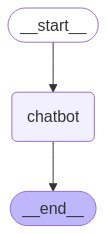

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: I'm **DeepSeek Chat**, an AI assistant created by **DeepSeek**, and here’s what I can do for you:  

### 🔍 **Knowledge & Assistance**  
- Answer questions on diverse topics (science, history, tech, entertainment, etc.).  
- Provide explanations, summaries, and detailed analyses.  
- Offer step-by-step problem-solving for math, coding, and logic puzzles.  

### 📄 **Document Processing**  
- Read and analyze uploaded documents (**PDFs, Word, Excel, PowerPoint, TXT**).  
- Extract key information, summarize content, or answer questions about the document.  

### 📝 **Writing & Editing**  
- Help with essays, reports, emails, and creative writing (stories, poems, scripts).  
- Rewrite, proofread, or refine your text for clarity and style.  

### 💻 **Coding & Tech Support**  
- Write, debug, and optimize code in Python, Java, C++, JavaScript, and more.  
- Explain programming concepts, algorithms, and best practices.  

### 🌍 **Translation & Language Skills**  
- Translate between

In [4]:
from langchain_core.tools import tool
from enum import Enum
from langchain_core.messages import HumanMessage, SystemMessage

class LocationEnum(str, Enum):
    kitchen = "kitchen"
    living_room = "living_room"
    bedroom = "bedroom"

@tool
def go_to_coordinates(x: float, y: float):
    """
    Move the robot to a specific set of coordinates.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If x or y is not a number.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'success', 'message': 'Moved to coordinates (10.5, 20.3)'}
    Example:
        >>> go_to_coordinates("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> go_to_coordinates(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move to coordinates (10.5, 20.3)'}
    """
    print(f"Moving to coordinates ({x}, {y})")
    # Here you would add the code to move the robot to the specified coordinates
    return {"status": "success", "message": f"Moved to coordinates ({x}, {y})"}

@tool
def go_to_location(location_name: LocationEnum):
    """
    Move the robot to a specific location.
    Args:
        location_name (LocationEnum): The name of the location.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If location_name is not a valid location.
    Example:
        >>> go_to_location("kitchen")
        {'status': 'success', 'message': 'Moved to location: kitchen'}
    Example:
        >>> go_to_location("garage")
        ValueError: location_name must be one of ['kitchen', 'living_room', 'bedroom'].
    Example:
        >>> go_to_location("living_room")
        {'status': 'failure', 'message': 'Failed to move to location: living_room'}
    """
    print(f"Moving to location: {location_name}")
    # Here you would add the code to move the robot to the specified location
    return {"status": "success", "message": f"Moved to location: {location_name}"}

@tool
def rotate(angle: float):
    """
    Rotate the robot to a specific angle.
    Args:
        angle (float): The angle to rotate to.
    Returns:
        dict: A dictionary containing the status and message.
    Raises:
        ValueError: If angle is not a number.
    Example:
        >>> rotate(90)
        {'status': 'success', 'message': 'Rotated to angle: 90'}
    Example:
        >>> rotate("90")
        ValueError: angle must be a number.
    Example:
        >>> rotate(90)
        {'status': 'failure', 'message': 'Failed to rotate to angle: 90'}
    """
    print(f"Rotating to angle: {angle}")
    # Here you would add the code to rotate the robot to the specified angle
    return {"status": "success", "message": f"Rotated to angle: {angle}"}

@tool
def get_pose():
    """
    Get the current pose of the robot.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> get_pose()
        {'status': 'success', 'message': 'Current pose: (x, y, theta)'}
    Example:
        >>> get_pose()
        {'status': 'failure', 'message': 'Failed to get pose'}
    """
    print("Getting current pose")
    # Here you would add the code to get the current pose of the robot
    return {"status": "success", "message": "Current pose: (x, y, theta)"}

@tool
def follow_person():
    """
    Follow a person.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> follow_person()
        {'status': 'success', 'message': 'Following person'}
    Example:
        >>> follow_person()
        {'status': 'failure', 'message': 'Failed to follow person'}
    """
    print("Following person")
    # Here you would add the code to follow a person
    return {"status": "success", "message": "Following person"}

nav_tools = [
    go_to_coordinates,
    go_to_location,
    rotate,
    get_pose,
    follow_person
]
nav_llm_with_tools = llm.bind_tools(nav_tools)

In [5]:
# Agent system prompts
sub_str = """
                'plan': \[
                            \{'tool': 'tool_name': parameters: \[param1,...,paramN\], 'parallel': True/False \},
                            ...
                        \]
        """
agent_sys_msg = lambda module: f"""You are the {module} head of a Robot, you have access to a set of tools that represent the robot's capabilities and
                        you are tasked with translating a user's natural language command to one of the available tools with the appropriate parameters.
                        Note that you can chain several tools together to fulfill a user command, you can also specify whether to run tools in parallel or sequentially.
                        You have a set of tools at your disposal, each with its own set of parameters, you can call the tools, but you must
                        also provide a concise reasoning for your choice in the tool_messages section for each one of the tool_calls.
                        """

planning_sys_msg = """You are the planning head of a robot that has several capabilities, you have access to several specialized agents,
                        each with its own set of capabilities.
                        You are tasked with finding the best plan to execute on the user's command based on the agents you have at disposal
                        and their capabilities.
                        You can also specify wheter to run commands sequentially or in parallel.
                        Your output should be very precise and concise.
                        The agent names are the following: ["conversation", "manipulation", "navigation", "vision"]
                        Output format:
                        'reasoning': Explain the overarching goal and how you plan to achieve it (be very concise)
                        'plan': \[
                                    \{'agent': 'agent_name', 'command': 'the command to be run by the agent', 'parallel': True/False \},
                                    ...
                                \]
                        """

In [6]:
from langgraph.graph import MessagesState
def navigation_agent(state: MessagesState):
    return {"messages": [nav_llm_with_tools.invoke([agent_sys_msg(module="navigation")] + state["messages"])]}

In [7]:
# Manipulation tools

@tool
def move_arm(x: float, y: float):
    """
    Move the robot's arm to a specific position.
    Args:
        x (float): The x coordinate.
        y (float): The y coordinate.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'success', 'message': 'Moved arm to coordinates (10.5, 20.3)'}
    Example:
        >>> move_arm("10.5", 20.3)
        ValueError: x and y must be numbers.
    Example:
        >>> move_arm(10.5, 20.3)
        {'status': 'failure', 'message': 'Failed to move arm to coordinates (10.5, 20.3)'}
    """
    print(f"Moving arm to coordinates ({x}, {y})")
    # Here you would add the code to move the robot's arm to the specified coordinates
    return {"status": "success", "message": f"Moved arm to coordinates ({x}, {y})"}

@tool
def move_joints(joint_angles: list):
    """
    Move the robot's joints to specific angles.
    Args:
        joint_angles (list): A list of joint angles.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'success', 'message': 'Moved joints to angles [30, 45, 60]'}
    Example:
        >>> move_joints("30, 45, 60")
        ValueError: joint_angles must be a list of numbers.
    Example:
        >>> move_joints([30, 45, 60])
        {'status': 'failure', 'message': 'Failed to move joints to angles [30, 45, 60]'}
    """
    print(f"Moving joints to angles {joint_angles}")
    # Here you would add the code to move the robot's joints to the specified angles
    return {"status": "success", "message": f"Moved joints to angles {joint_angles}"}

@tool
def pick_up_object(object_name: str):
    """
    Pick up an object.
    Args:
        object_name (str): The name of the object to pick up.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> pick_up_object("box")
        {'status': 'success', 'message': 'Picked up object: box'}
    Example:
        >>> pick_up_object(123)
        ValueError: object_name must be a string.
    Example:
        >>> pick_up_object("box")
        {'status': 'failure', 'message': 'Failed to pick up object: box'}
    """
    print(f"Picking up object: {object_name}")
    # Here you would add the code to pick up the specified object
    return {"status": "success", "message": f"Picked up object: {object_name}"}

@tool
def press_button(button_name: str):
    """
    Press a button.
    Args:
        button_name (str): The name of the button to press.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> press_button("start")
        {'status': 'success', 'message': 'Pressed button: start'}
    Example:
        >>> press_button(123)
        ValueError: button_name must be a string.
    Example:
        >>> press_button("start")
        {'status': 'failure', 'message': 'Failed to press button: start'}
    """
    print(f"Pressing button: {button_name}")
    # Here you would add the code to press the specified button
    return {"status": "success", "message": f"Pressed button: {button_name}"}

manip_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )

manip_tools = [
    move_arm,
    move_joints,
    pick_up_object
]
manip_llm_with_tools = manip_llm.bind_tools(manip_tools)
def manipulation_agent(state: MessagesState):
    return {"messages": [manip_llm_with_tools.invoke([agent_sys_msg(module="navigation")] + state["messages"])]}

In [8]:
from typing import Optional, List

In [9]:
# Vision tools

@tool
def take_picture():
    """
    Take a picture.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> take_picture()
        {'status': 'success', 'message': 'Picture taken'}
    Example:
        >>> take_picture()
        {'status': 'failure', 'message': 'Failed to take picture'}
    """
    print("Taking picture")
    # Here you would add the code to take a picture
    return {"status": "success", "message": "Picture taken"}

@tool
def detect_objects(objects: List[str]):
    """
    Detect objects in the environment.
    Args:
        objects (List[str]): A list of object names to detect.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> detect_objects(["box", "chair"])
        {'status': 'success', 'message': 'Detected objects: box, chair'}
    Example:
        >>> detect_objects("box, chair")
        ValueError: objects must be a list of strings.
    Example:
        >>> detect_objects(["box", "chair"])
        {'status': 'failure', 'message': 'Failed to detect objects: box, chair'}
    """
    print(f"Detecting objects: {objects}")
    # Here you would add the code to detect the specified objects
    return {"status": "success", "message": f"Detected objects: {', '.join(objects)}"}

@tool
def recognize_text():
    """
    Recognize text in the environment.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> recognize_text()
        {'status': 'success', 'message': 'Recognized text: Hello, world!'}
    Example:
        >>> recognize_text()
        {'status': 'failure', 'message': 'Failed to recognize text'}
    """
    print("Recognizing text")
    # Here you would add the code to recognize text
    return {"status": "success", "message": "Recognized text: Hello, world!"}

@tool
def semantic_segmentation():
    """
    Perform semantic segmentation.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> semantic_segmentation()
        {'status': 'success', 'message': 'Semantic segmentation completed'}
    Example:
        >>> semantic_segmentation()
        {'status': 'failure', 'message': 'Failed to perform semantic segmentation'}
    """
    print("Performing semantic segmentation")
    # Here you would add the code to perform semantic segmentation
    return {"status": "success", "message": "Semantic segmentation completed"}

vision_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )

vision_tools = [
    take_picture,
    detect_objects,
    recognize_text,
    semantic_segmentation
]

vision_llm_with_tools = vision_llm.bind_tools(vision_tools)
def vision_agent(state: MessagesState):
    return {"messages": [vision_llm_with_tools.invoke([agent_sys_msg(module="vision")] + state["messages"])]}

In [10]:
# Conversational tools
@tool
def clarify(context: str, question: str):
    """
    Clarify a question based on the context.
    Args:
        context (str): The context to clarify the question.
        question (str): The question to clarify.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'success', 'message': 'The robot is in the kitchen.'}
    Example:
        >>> clarify("The robot is in the kitchen.", 123)
        ValueError: question must be a string.
    Example:
        >>> clarify("The robot is in the kitchen.", "Where is the robot?")
        {'status': 'failure', 'message': 'Failed to clarify the question.'}
    """
    print(f"Clarifying question: {question} based on context: {context}")
    # Here you would add the code to clarify the question based on the context
    return {"status": "success", "message": f"The robot is in the kitchen."}

@tool
def speak(text: str):
    """
    Speak a given text.
    Args:
        text (str): The text to speak.
    Returns:
        dict: A dictionary containing the status and message.
    Example:
        >>> speak("Hello, world!")
        {'status': 'success', 'message': 'Spoken text: Hello, world!'}
    Example:
        >>> speak(123)
        ValueError: text must be a string.
    Example:
        >>> speak("Hello, world!")
        {'status': 'failure', 'message': 'Failed to speak text: Hello, world!'}
    """
    print(f"Speaking text: {text}")
    # Here you would add the code to speak the given text
    return {"status": "success", "message": f"Spoken text: {text}"}

conv_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=500
    )

conv_tools = [
    clarify,
    speak
]
conv_llm_with_tools = conv_llm.bind_tools(conv_tools)
def conv_agent(state: MessagesState):
    return {"messages": [conv_llm_with_tools.invoke([agent_sys_msg(module="conversation")] + state["messages"])]}

In [11]:
planning_llm = ChatOpenAI(
        
        model=model_id,
        temperature=0.1,
        max_completion_tokens=1000
    )

def planning_agent(state: MessagesState):
    return {"messages": [planning_llm.invoke([planning_sys_msg] + state["messages"])]}

In [12]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import tools_condition, ToolNode
from IPython.display import Image, display
from ast import literal_eval
import json
import re

# Graph
builder = StateGraph(State)

# Add the nodes to the graph
builder.add_node("planning", planning_agent)
builder.add_node("conversation", conv_agent)
builder.add_node("manipulation", manipulation_agent)
builder.add_node("navigation", navigation_agent)
builder.add_node("vision", vision_agent)

# Define the edges of the graph
builder.add_edge(START, "planning")

# Define a condition function to route messages based on the planning agent's decision
def route_to_agent(state):
    # Get the last message from the assistant (which should be from the planning agent)
    last_message = state["messages"][-1]
    
    if "plan" not in last_message.content:
        return END
    
    # Try to extract the plan from the message content
    # Use regex to extract JSON structure
    pattern = r'\[.*?\]'
    match = re.search(pattern, last_message.content, re.DOTALL)
    
    if match:
        try:
            plan_data = literal_eval(match.group().replace("\\{", "{").replace("\\}", "}").replace("\[", "[").replace("\]", "]").replace("\\'", "'"))
            if len(plan_data) > 0:
                # Get the first agent in the plan
                next_step = plan_data[0]
                next_agent = next_step["agent"]
                
                # Update the original state with the modified plan (for future steps)
                if plan_data:
                    last_message.content = json.dumps(plan_data)
                
                # Return the next agent to call along with the new state
                if next_agent in ["conversation", "manipulation", "navigation", "vision"]:
                    return next_agent
        except json.JSONDecodeError:
            pass

    print("No valid plan found or unable to parse the plan.")
    
    return END

# Add conditional edges from planning to other agents
builder.add_conditional_edges(
    "planning",
    route_to_agent,
    {
        "conversation": "conversation",
        "manipulation": "manipulation",
        "navigation": "navigation",
        "vision": "vision",
        END: END
    }
)

# Add edges from other agents back to planning or to END
# builder.add_edge("conversation", "planning")
# builder.add_edge("manipulation", "planning")
# builder.add_edge("navigation", "planning")
# builder.add_edge("vision", "planning")

builder.add_edge(["conversation", "manipulation", "navigation", "vision"], END)

# Compile the graph
react_graph = builder.compile()


In [13]:
messages = [HumanMessage(content="Can you pick up the banana?")]

for chunk in react_graph.stream({"messages": messages}, stream_mode="messages", debug=True):
    pass

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={})]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={})]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={}, id='0d152d9d-8207-489a-bf56-52df34d49116')]}
[1:tasks] Starting 1 task for step 1:
- planning -> {'messages': [HumanMessage(content='Can you pick up the banana?', additional_kwargs={}, response_metadata={}, id='0d152d9d-8207-489a-bf56-52df34d49116')]}
[1:writes] Finished step 1 with writes to 1 channel:
- messages -> [AIMessage(content='[{"agent": "vision", "command": "locate the banana", "parallel": false}, {"agent": "manipulation", "command": "pick 